**Pool Performance and TVL Evaluation**

This script will be used to explore pool performance and TVL. This script will focus on non-stable coin pools.

In the script, we will:

1. Create a scatter plot to show the relationship between pool TVL and 7-day return
2. Add a column for the percentile rank of the pool 7-day return
3. Explore what are the best performing pools and projects
4. Create a table that has provides a league standing of pools with pool name, pool id, chain, protocol, tvl, 7 day change in TVL, APY, 7 day, 30 day apy,  7day mean apy divided by 7 day std dev, 7 day apy percentile, 30 day apy percentile, tvl percentile, 7 day apy percentile
5. Create a function that plots a line graph of the 7 day APY for a pool over time based on a list of pool ids
6. add a new column to the table called 'SD_Score' which is the product of '7 day APY percentile' and 'tvl percentile' multiplied by 100
7. create another column called 'SD_Score_std' which is the standard deviation of the SD_Score over the last 7 days




In [1]:
# Import libraries and dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from datetime import timedelta

data = pd.read_csv(r'/Users/karolk/Python_Work/Data_Sets/Global_Data/DeFi_Global_DB.csv', index_col=0)
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)
pd.options.display.float_format = '{:,.2f}'.format

display(data.head(100))


,chain,project,symbol,tvlUsd,apy,pool,stablecoin,ilRisk,exposure,outlier,apyMean30d,date,time added,new_upload,possible_error
id,,,,,,,,,,,,,,,
2505286,Ethereum,uniswap-v2,BLOCK-WETH,"216,991.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-12-03,2023-12-03 07:01:18,False,False
2492795,Ethereum,uniswap-v2,BLOCK-WETH,"204,392.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-12-02,2023-12-02 07:01:20,False,False
2480300,Ethereum,uniswap-v2,BLOCK-WETH,"194,546.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-12-01,2023-12-01 07:01:34,False,False
2467503,Ethereum,uniswap-v2,BLOCK-WETH,"206,344.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-11-30,2023-11-30 07:09:43,False,False
2454924,Ethereum,uniswap-v2,BLOCK-WETH,"209,586.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-11-29,2023-11-29 07:08:22,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597166,Ethereum,uniswap-v3,AIN-WETH,"113,203.00",0.59,fffcf7fb-131b-493c-b1e3-b3b7aa389c88,False,yes,multi,False,0.86,2023-06-16,2023-06-16 07:00:07,False,False
584719,Ethereum,uniswap-v3,AIN-WETH,"113,203.00",0.59,fffcf7fb-131b-493c-b1e3-b3b7aa389c88,False,yes,multi,False,0.93,2023-06-15,2023-06-15 09:00:25,False,False
572306,Ethereum,uniswap-v3,AIN-WETH,"113,260.00",0.59,fffcf7fb-131b-493c-b1e3-b3b7aa389c88,False,yes,multi,False,1.10,2023-06-14,2023-06-14 07:00:08,False,False


In [2]:
#set date and time added as datetime objects
data['date'] = pd.to_datetime(data['date'])
data['time added'] = pd.to_datetime(data['time added'])

#drop all pools that have a TVL of 0 or a APY of 0
data = data[(data['tvlUsd'] > 0) & (data['apy'] > 0)]

#select only non-stablecoin pools
data = data[data['stablecoin'] == False]

#sort the data table by pool and by date
data = data.sort_values(['pool', 'date'], ascending=[True, True]).reset_index(drop=True)

#create a new column which would the average APY over the last 7 days using the 'apy' column
data['apyMean7d'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).mean())

#create a new column for the standard deviation of the APY over the last 7 days
data['apyStd7d'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).std())

#create a column which has the percentile for TVL for the TVL at each date
data['tvlPercentile'] = data.groupby('date')['tvlUsd'].rank(pct=True)

#create a column which has the percentile for 7 day APY and 30 day APY
data['apy7DPercentile'] = data.groupby('date')['apyMean7d'].rank(pct=True)
data['apy30DPercentile'] = data.groupby('date')['apyMean30d'].rank(pct=True)

#create a new column in 'data' to categorize the pools by their 7 day and 30 day APY using the following groupings 0-5%, 5-10%, 10-15%, 15-20%, 20-25%, 25%+
data['apy7DGroup'] = pd.cut(data['apyMean7d'], bins=[0, 5, 10, 15, 20, 25, 100], labels=['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+'])
data['apy30DGroup'] = pd.cut(data['apyMean30d'], bins=[0, 5, 10, 15, 20, 25, 100], labels=['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+'])

#creating 2 new columns which is the average APY for 7 days divided by the standard deviation of the APY for 7 days
data['apy7DStdRatio'] = data['apyMean7d'] / data['apyStd7d']

#adding a column to categorize the pools by their percentile rank of TVL, 7day and 30 day rank using 10 bins
data['tvlPercGroup'] = pd.cut(data['tvlPercentile'], bins=10, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])
data['apy7DPercGroup'] = pd.cut(data['apy7DPercentile'], bins=10, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])
data['apy30DPercGroup'] = pd.cut(data['apy30DPercentile'], bins=10, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

#calculate a new column for the change in TVL over the last 7 days
data['tvlChange7d'] = data.groupby(['pool'])['tvlUsd'].pct_change(periods=7) * 100

data['tvlChange1d'] = data.groupby(['pool'])['tvlUsd'].pct_change(periods=1) * 100

#creating column with 'SD_Score' which is the product of '7 day APY percentile' and 'tvl percentile' multiplied by 100
data['SD_Score'] = data['apy7DPercentile'] * data['tvlPercentile'] * 100

#creating a column 'SD_Score_7D' which is the rolling mean of the past 7 days SD score
data['SD_Score_7D_avg'] = data.groupby('pool')['SD_Score'].transform(lambda x: x.rolling(7, 1).mean())

#create a column 'SD_Score_7D_std' which is the standard deviation of the SD_Score_7D over the last 7 days
data['SD_Score_7D_std'] = data.groupby('pool')['SD_Score'].transform(lambda x: x.rolling(7, 1).std())

In [3]:
#checking summary statistics of SD Score
display(data['SD_Score'].describe())




count   1,742,312.00
mean           24.44
std            20.55
min             0.00
25%             6.86
50%            19.21
75%            38.01
max            99.09
Name: SD_Score, dtype: float64

In [4]:
#display(data.head())

#display data for 1 pool
check = (data[data['pool'] == '3aaa3263-f577-4ae5-8eef-797fde687f64'])

#slect only the data for 'pool', 'date', 'tvl', 'apy' , 'apyMean7d', 'apyStd7d','tvlChange7d', 'tvlChange1d'
check = check[['pool', 'date', 'tvlUsd', 'apy', 'apyMean7d', 'apyStd7d','tvlChange7d', 'tvlChange1d', 'SD_Score', 'SD_Score_7D_avg', 'SD_Score_7D_std']]

check


,pool,date,tvlUsd,apy,apyMean7d,apyStd7d,tvlChange7d,tvlChange1d,SD_Score,SD_Score_7D_avg,SD_Score_7D_std
390810,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-02-15,"115,239,116.00",8.30,8.30,NaN,NaN,NaN,48.56,48.56,NaN
390811,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-02-22,"125,861,817.00",5.95,7.13,1.66,NaN,9.22,43.30,45.93,3.72
390812,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-03-01,"121,265,644.00",4.83,6.36,1.77,NaN,-3.65,38.94,43.60,4.82
390813,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-03-08,"114,658,692.00",3.51,5.65,2.03,NaN,-5.45,36.77,41.89,5.21
390814,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-03-15,"121,348,114.00",7.93,6.11,2.03,NaN,5.83,38.49,41.21,4.76
...,...,...,...,...,...,...,...,...,...,...,...
390961,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-10-03,"57,481,826.00",2.81,2.62,0.32,8.20,0.00,36.21,37.05,0.76
390962,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-10-04,"57,481,826.00",2.81,2.67,0.32,7.83,0.00,35.82,36.72,0.69
390963,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-10-05,"57,481,826.00",2.81,2.79,0.04,7.93,0.00,36.72,36.55,0.47
390964,3aaa3263-f577-4ae5-8eef-797fde687f64,2023-10-06,"57,481,826.00",2.81,2.81,0.00,3.11,0.00,36.97,36.55,0.47


In [5]:

#create all the needed tables for the scatter plot
latest_non_stables = data[data['date'] == data['date'].max()]
#select only stablecoin pools for the latest_non_stables dataframe
#latest_non_stables = latest_non_stables[latest_non_stables['stablecoin'] == True]

#create tables to look at total locked in value by chain and protocol
TVL_chain = latest_non_stables.pivot_table(index='chain', values='tvlUsd', aggfunc='sum').sort_values('tvlUsd', ascending=False).head(10)
#TVL by protocol
TVL_protocol = latest_non_stables.pivot_table(index='project', values='tvlUsd', aggfunc='sum').sort_values('tvlUsd', ascending=False).head(30)

#create a new column to identify top 10 chains named 'top_10_chain'
latest_non_stables['top_10_chain'] = latest_non_stables['chain'].isin(TVL_chain.index)

#create a new column to identify top 30 protocols named 'top_30_project'
latest_non_stables['top_30_project'] = latest_non_stables['project'].isin(TVL_protocol.index)

#setting up a cut of data with only largest chains and largest protocols
APY_analysis = latest_non_stables[(latest_non_stables['top_10_chain']) & (latest_non_stables['top_30_project'])]

#creating 3 dataframe to sum the number of pools in each grouping for TVLPercGroup, 7 day APY and 30 day APY groupings

tvl_count = APY_analysis.groupby('tvlPercGroup').count()['pool']
apy7d_count = APY_analysis.groupby('apy7DPercGroup').count()['pool']
apy30d_count = APY_analysis.groupby('apy30DPercGroup').count()['pool']


/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_29439/3710537756.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_non_stables['top_10_chain'] = latest_non_stables['chain'].isin(TVL_chain.index)
/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_29439/3710537756.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_non_stables['top_30_project'] = latest_non_stables['project'].isin(TVL_protocol.index)


In [6]:
# Setting the plotting theme
sns.set_theme(style="ticks", context='talk')

#importing image for watermark
img = Image.open(r'/Users/karolk/Python_Work/Data_Sets/logo.png')

#setting up font for chart
fontpath = '/System/Library/Fonts/Optima.ttc'
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()

#creating string that says "Data updated as of: mmm dd yyyy"
date = latest_non_stables['date'].max()
date = pd.to_datetime(date)
date = date.strftime('%b %d %Y')
date = 'Data updated as of: ' + date


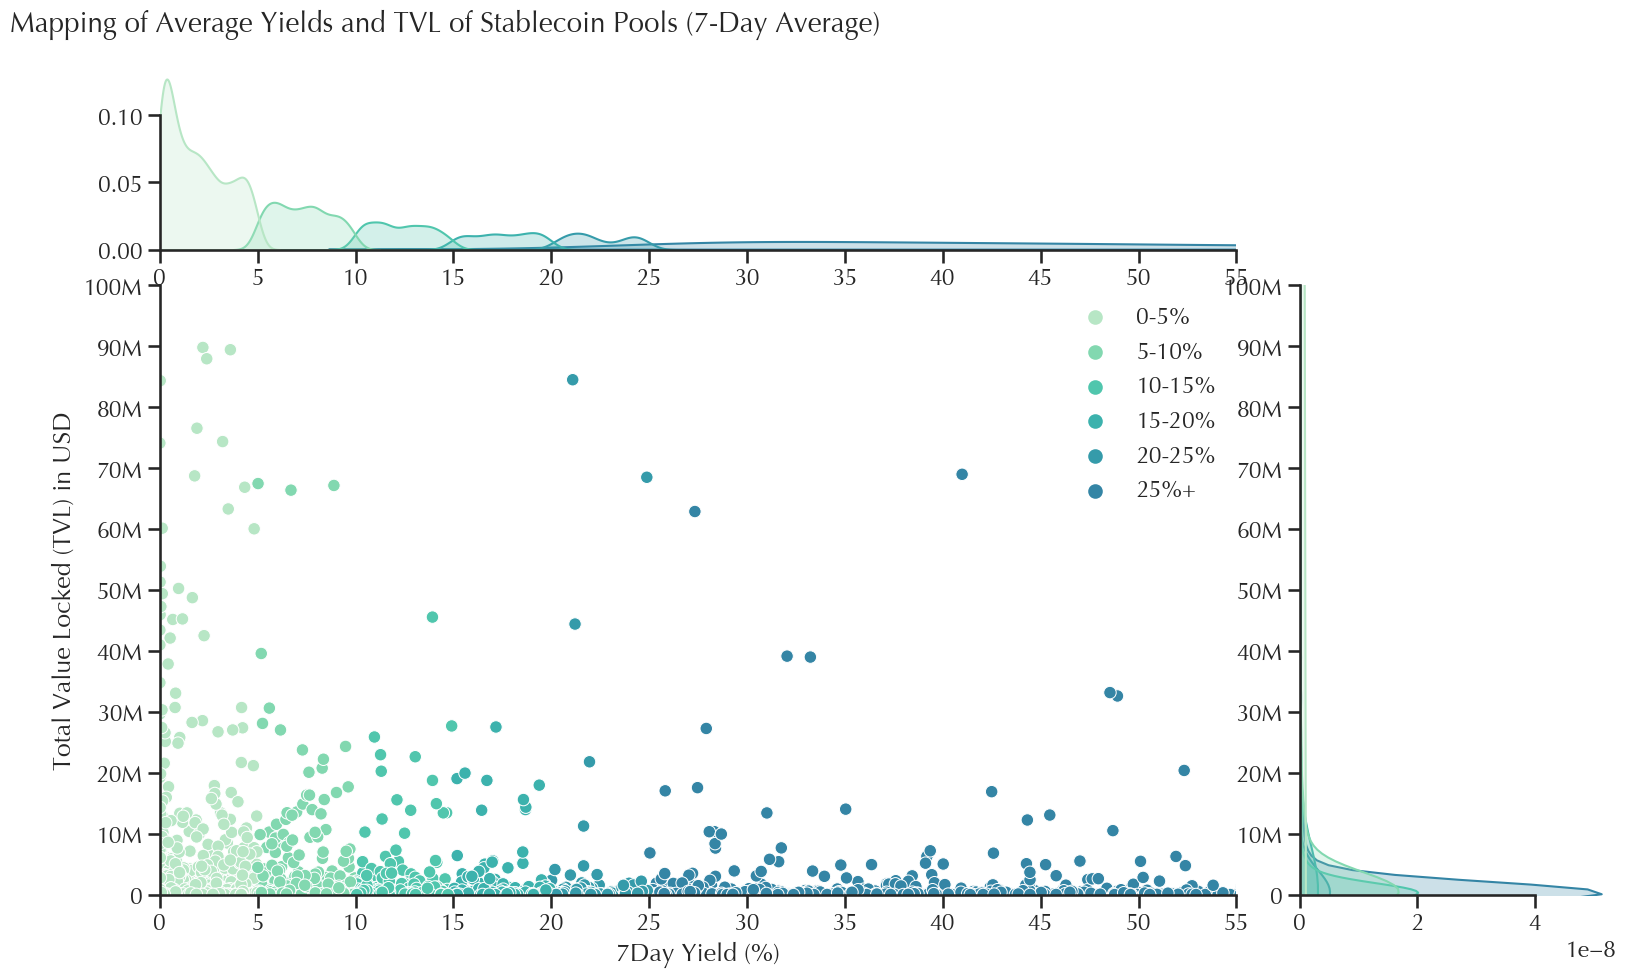

In [7]:
#Creating a joinplot to visualize a smaller universe of investable assets, select a subset of the data that shows 75% of the data excluding outliers

#setting color palatte for chart
sns.set_palette("mako_r",12)

#create chart
g = sns.jointplot(x='apyMean7d', y='tvlUsd', data=APY_analysis,
                  height=15, ratio=3, space=0.2, hue='apy7DGroup',
                  xlim=(0, 50), ylim=(2000000, 100000000), kind='scatter')


#setting the title and labels
g.fig.suptitle('Mapping of Average Yields and TVL of Stablecoin Pools (7-Day Average)',
               y=1.05, size=20, weight='bold', x=0.25)
plt.xlabel('7Day Yield (%)')
plt.ylabel('Total Value Locked (TVL) in USD')


#set the legend location
plt.legend(loc='best', frameon=False)

#set size of chart
g.fig.set_size_inches(16, 9)

#adjusting the tick marks
plt.yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], ['0','10M', '20M', '30M', '40M', '50M', '60M', '70M', '80M', '90M', '100M'])
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])

#despine the plot
sns.despine(trim=True, offset=0)

#save the figure
plt.show()
plt.cla()
plt.clf()
plt.close()

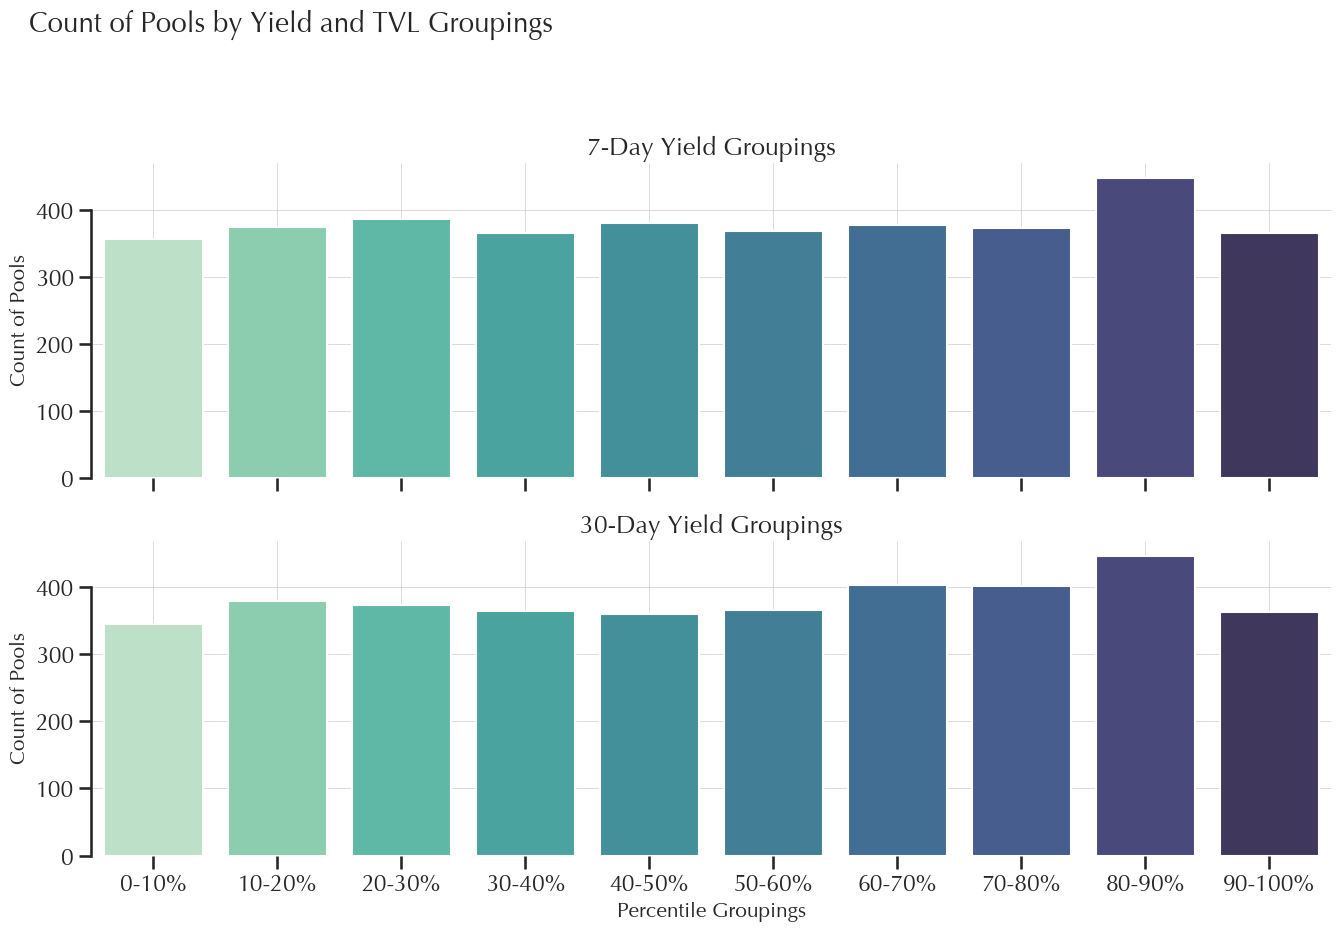

In [8]:
#create a bar graph with a shared x-axis for the count of pools in each grouping for TVL, 7 day APY and 30 day APY

#setting color palatte for chart
sns.set_palette("mako_r",12)

#create chart
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9))

#plot the data
sns.barplot(x=apy7d_count.index, y=apy7d_count, ax=ax1)
sns.barplot(x=apy30d_count.index, y=apy30d_count, ax=ax2)

#set the title and labels
fig.suptitle('Count of Pools by Yield and TVL Groupings', y=1.05, size=20, weight='bold', x=0.25)
ax1.set_ylabel('Count of Pools', size=15)
ax2.set_ylabel('Count of Pools', size=15)
ax2.set_xlabel('Percentile Groupings', size=15)
ax1.set_xlabel(None)

#setting title for each subplot
ax1.set_title('7-Day Yield Groupings')
ax2.set_title('30-Day Yield Groupings')

#make grid lines thinner
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)

#despine the plot
sns.despine(trim=True, bottom=True, offset=0)

#showing the figure
plt.show()
plt.cla()
plt.clf()
plt.close()



In [9]:
#create pool league standing dataframe which contains the following columns: 'pool name', 'pool id', 'chain', 'protocol', 'tvl', '7 day' 'change in TVL', 'APY', '7 day apy', '30 day apy',  '7day mean apy divided by 7 day std dev', '7 day apy percentile' '30 day apy percentile', 'tvl percentile', '7 day apy percentile'

#start with getting the list of all the columns in the data dataframe

columns_2_keep = [ 'date', 'chain', 'project', 'pool', 'symbol', 'tvlUsd',
                   'tvlChange1d', 'tvlChange7d' , 'apy', 'apyMean7d',
                   'apyStd7d', 'apyMean30d', 'apy7DStdRatio', 'SD_Score',
                   'SD_Score_7D_avg','stablecoin']

#creating a new dataframe with only the columns we want
pool_league_standings = data[columns_2_keep]

#creating a new dataframe with only rows where data is the latest date and 'stablecoin' is 'True'
pool_league_non_stable = pool_league_standings[(pool_league_standings['date'] == pool_league_standings['date'].max())]

#sort the dataframe by SD_score and select the top 10 pools
top10_league_stable = pool_league_non_stable.sort_values(by='SD_Score_7D_avg', ascending=False).head(20)

#in the top10_league_stable dataframe, we will only keep the following columns: 'SD_Score_7D_avg', 'chain', 'project', 'symbol', 'tvlUsd', 'tvlChange7d' , 'apy', 'apyMean7d'
top10_league_stable = top10_league_stable[['SD_Score_7D_avg', 'chain', 'project', 'symbol', 'tvlUsd', 'tvlChange7d' , 'apy', 'apyMean7d']]

#making tvl in millions by dividing by 1 million
top10_league_stable['tvlUsd'] = top10_league_stable['tvlUsd'] / 1000000

#rounding the all numeric columns to 2 decimal places
top10_league_stable = top10_league_stable.round(2)

#renaming the columns
top10_league_stable = top10_league_stable.rename(columns={'SD_Score_7D_avg': 'SD Score', 'chain': 'Chain', 'project': 'Protocol', 'symbol': 'Symbol', 'tvlUsd': 'TVL (Millions)', 'tvlChange7d': 'TVL Change (7D)' , 'apy': 'APY (%)', 'apyMean7d': '7D APY (%)'})

#saving the dataframe to csv
top10_league_stable.to_csv('/Users/karolk/Python_Work/Yield_Analysis/League_Standings/top10_league_non_stable.csv')

#sort the data frame by TVL and select the top 10 pools
top10TVL_league_stable = pool_league_non_stable.sort_values(by='tvlUsd', ascending=False).head(15)

#sort the data frame by TVL and select the top 10 pools
top10APY_league_stable = pool_league_non_stable.sort_values(by='apyMean7d', ascending=False).head(15)

#save the top10TVL and top10APY dataframes to csv
top10TVL_league_stable.to_csv('/Users/karolk/Python_Work/Yield_Analysis/League_Standings/top10TVL_league_non_stable.csv')
top10APY_league_stable.to_csv('/Users/karolk/Python_Work/Yield_Analysis/League_Standings/top10APY_league_non_stable.csv')

# view 10APY_league_stable
top10_league_stable




,SD Score,Chain,Protocol,Symbol,TVL (Millions),TVL Change (7D),APY (%),7D APY (%)
164834,93.29,Avalanche,joe-v2.1,WAVAX-USDC,7.50,22.74,454.51,789.56
38719,93.11,Solana,kamino-liquidity,JTO-JITOSOL,7.18,-4.64,52.93,113.64
483976,92.95,Solana,orca,SOL-BONK,7.87,49.48,638.08,823.61
1684880,91.47,Ethereum,uniswap-v3,MUBI-WETH,7.32,104.37,"1,762.56","1,160.22"
282615,90.24,Solana,orca,JTO-USDC,2.79,10.41,181.78,741.42
587602,90.10,Solana,orca,JTO-JITOSOL,7.93,-0.86,47.07,83.94
495947,90.02,Ethereum,pancakeswap-amm-v3,RETH-WETH,6.43,-24.20,25.50,"3,051.84"
482803,88.75,Ethereum,uniswap-v3,WETH-BSSB,4.62,203.95,"1,295.39","1,124.10"
1383206,88.44,Solana,orca,SOL-USDC,5.12,-3.90,178.65,300.14
1117561,88.34,Solana,orca,BONK-USDC,5.09,240.50,701.94,"1,110.32"


In [10]:
# extracting the symbols from the pool_league_non_stable dataframe. 
symbols = pool_league_non_stable['symbol'].unique().tolist()

# creating 2 list one without any dashes in the name and one with dashes
symbols_no_dash = []
symbols_dash = []

for symbol in symbols:
    if '-' in symbol:
        symbols_dash.append(symbol)
    else:
        symbols_no_dash.append(symbol)
        
        
# for the list with dashes, we will remove the dash in between each symbol and it the seperated symbols to the list with no dashes
for symbol in symbols_dash:
    symbol = symbol.split('-')
    for i in symbol:
        symbols_no_dash.append(i)
        
# keep only the unique symbols in the no dash list
symbols_no_dash = list(set(symbols_no_dash))

# sort the no dash list by ascending order
symbols_no_dash.sort()

#save the list for it to be available to other scripts
np.save('/Users/karolk/Python_Work/Data_Sets/Pool_Standings/symbols_no_dash.npy', symbols_no_dash)

symbols_no_dash


['',
 '$50',
 '$ADS',
 '$AOT',
 '$BIF',
 '$BLUEBERRY',
 '$BNTX',
 '$BOG',
 '$BOJACK',
 '$BYC',
 '$CITY',
 '$DEZ',
 '$DMB',
 '$FANG',
 '$FRNK',
 '$GARBAGE',
 '$GARY',
 '$KMC',
 '$MANLET',
 '$MECHA',
 '$MUMU',
 '$MUSIC',
 '$MYCAC',
 '$MYRO',
 '$NPOE',
 '$OIL',
 '$PAAL',
 '$PNDC',
 '$RKT',
 '$SHARBI',
 '$SLT',
 '$SLURP',
 '$SOY',
 '$SWTS',
 '$TOLY',
 '$USE',
 '$WEN',
 '$WIF',
 '$WNZ',
 '$YETI',
 '05D299885B07905B6886F554B39346EA6761246076A1120B1950049B92B922DD',
 '100',
 '108',
 '150',
 '1FLR',
 '1INCH',
 '2080',
 '20WETH',
 '2500',
 '2BRL',
 '2CHF(VCHF)',
 '2CRV',
 '3000',
 '3CRV',
 '3CRYPTO',
 '3KGL',
 '3POOL',
 '3USD',
 '4D4B520000000000000000000000000000000000000000000000000000000000',
 '4DMAPS',
 '4HALV',
 '4NUTS',
 '4POOL',
 '500',
 '50IQ',
 '58923AAE6E879D7CB5FB0F2F05550FD4F696099AB0F5CDF0A05CC0309DD8BC78',
 '7EDDFNF4MKU8SO3T4DO215GNHWASEWCWRDHM5GQD51XZ',
 '800',
 '80BAL',
 '871JBN9UNTAVWSAE83F2MA9GJWSV6BKSYWYLIQ6Z3PVA',
 '9598CDEB7C6DB7FC21E746C8E0250B30CD5154F39CA111A9D4948A4362F

In [11]:
#creating a seaborn histogram plot of the 7 day average SD score for all pools

#creating a funcntion to plot histogram of SD Score

def plot_SD_hist(hue, title, save_path, legend_title):

    #setting up font for chart
    fontpath = '/System/Library/Fonts/Optima.ttc'
    prop = font_manager.FontProperties(fname=fontpath)
    plt.rcParams['font.family'] = prop.get_name()

    #create figure and axis
    fig, ax = plt.subplots(figsize=(16, 9))

    #change legend to smaller font
    plt.rcParams['legend.fontsize'] = 10

    #creating a histogram of the data
    sns.histplot(data=APY_analysis, x='SD_Score_7D_avg', palette='mako_r', multiple='stack',
                 hue=hue, bins=30, linewidth=0.3, edgecolor=".3", ax=ax)

    #importing image for watermark
    img = Image.open(r'/Users/karolk/Python_Work/Data_Sets/logo.png')

    #adding watermark
    imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
    imagebox.image.axes = ax
    ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
    ao.patch.set_alpha(0)
    ax.add_artist(ao)

    #despine the plot to keep only y and x axis
    sns.despine(offset=0, bottom=False, left=False)

    #setting the title and labels
    ax.set_title(title,
                 y=1.05, weight='bold', x=0.15, size=20)

    #setting the x and y labels
    ax.set_xlabel('7 Day Avg SD Score', size=10)
    ax.set_ylabel('Count of Pools', size=10)

    #set the font size of x and y ticks
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    #change legend to smaller font
    plt.rcParams['legend.fontsize'] = 10

    #remove frame from legend
    ax.get_legend().set_frame_on(False)

    #remove title from legend
    ax.get_legend().set_title(legend_title)

    #add a very fine grid to the plot
    ax.grid(visible=True, which='major', linestyle='-', alpha=0.2)

    #update font for plot to the font we set up
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontproperties(prop)

        #save the figure
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

    #showing the figure
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    #end of function

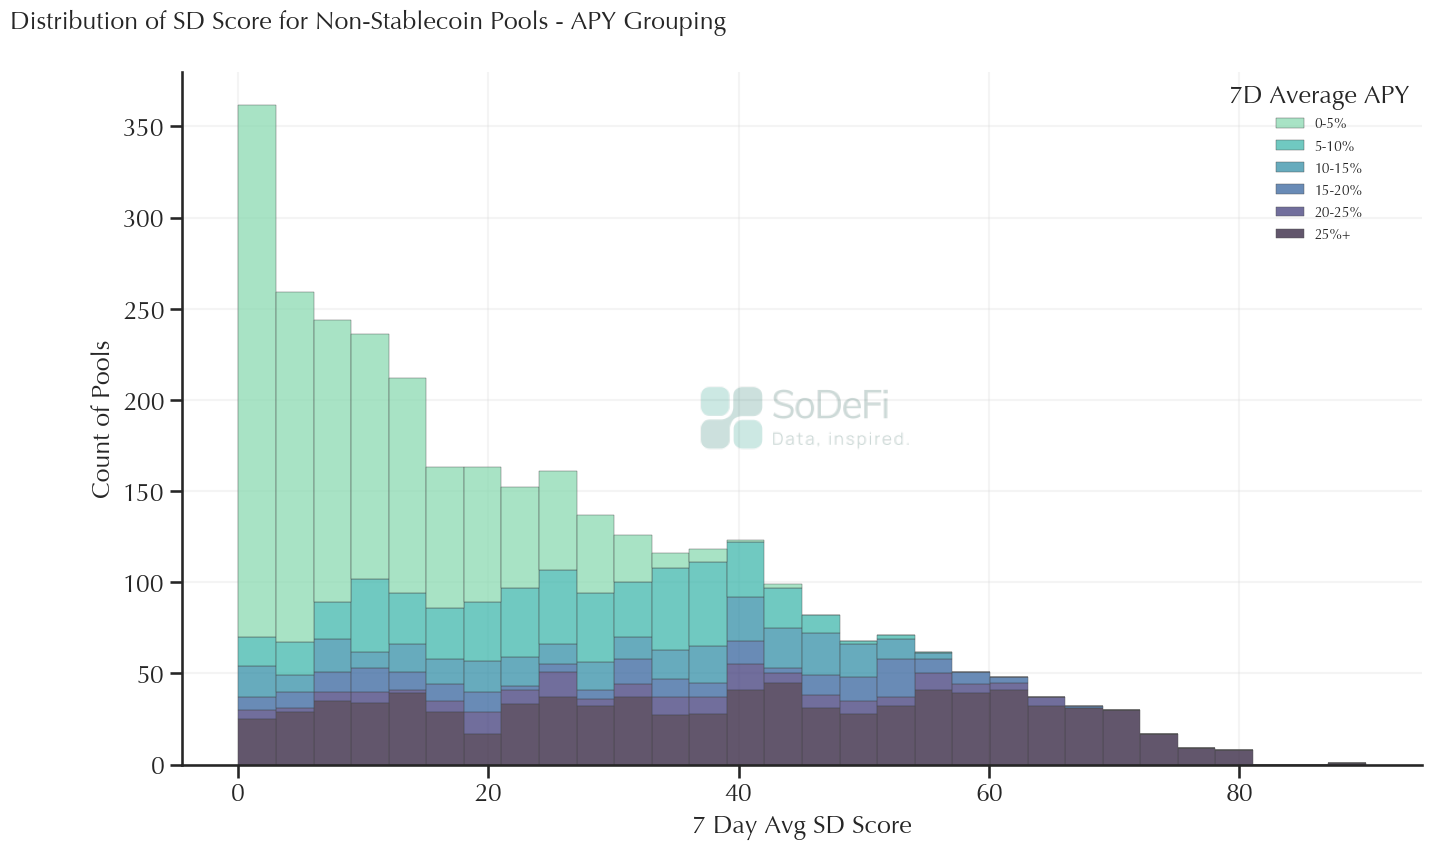

In [12]:
save_path_hist1 = '/Users/karolk/Python_Work/Yield_Analysis/Charts/SD_Score_Hist3.png'
legendtitle1 = '7D Average APY'
hue1 = APY_analysis['apy7DGroup']

plot_SD_hist(hue1, 'Distribution of SD Score for Non-Stablecoin Pools - APY Grouping', save_path_hist1, legendtitle1)

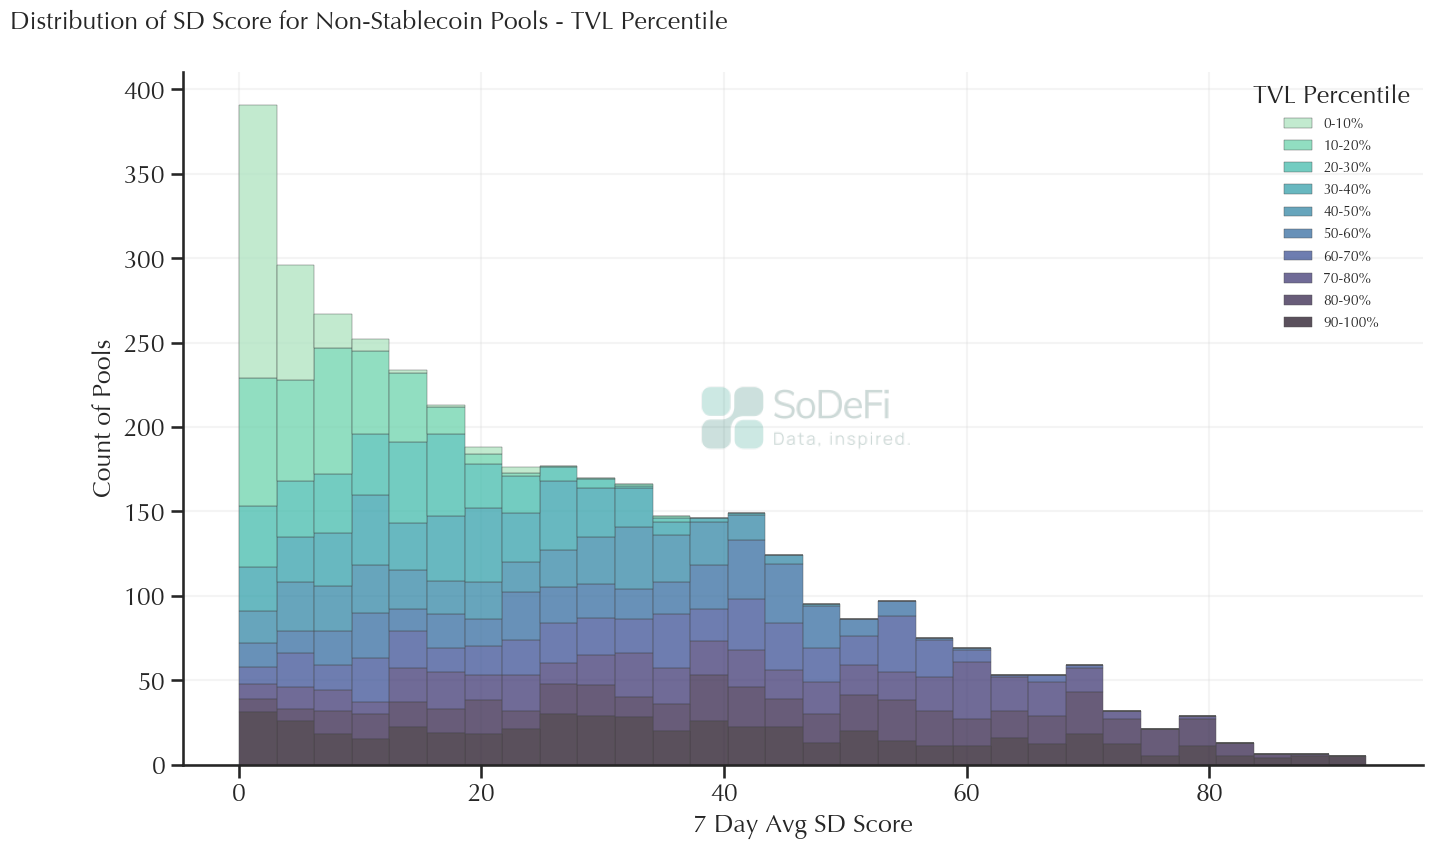

In [13]:
hue2 = APY_analysis['tvlPercGroup']
legendtitle2 = 'TVL Percentile'
save_path_hist2 = '/Users/karolk/Python_Work/Yield_Analysis/Charts/SD_Score_Hist4.png'
plot_SD_hist(hue2, 'Distribution of SD Score for Non-Stablecoin Pools - TVL Percentile', save_path_hist2, legendtitle2)